In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import json
from collections import Counter
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Import population

In [ ]:
#Import population in Boston
boston_pop = pd.read_csv ('drive/MyDrive/Amenities/output/bigquery_BUA_population.csv', index_col = False)
boston_pop['person_id'] = boston_pop['person_id'].astype(float)
pop=len(boston_pop)

# Import frequency

In [ ]:
#Import frequency info
frequency=pd.read_csv('drive/MyDrive/Amenities/output/BUA_analysis_month2.csv', index_col = False)

# Import trips

In [ ]:
##Import trip info
trips_sa = pd.read_csv ('drive/MyDrive/Amenities/output/BUA_trips_bga_sa_amenitiesadded2.csv', index_col = False)
trips_th = pd.read_csv ('drive/MyDrive/Amenities/output/BUA_trips_bga_th_amenitiesadded2.csv', index_col = False)
trips_sa.head(2)

,activity_id,person_id,household_id,mode,duration_minutes,distance_miles,origin_bgrp,destination_bgrp,naics_category,placekey,naics_code,location_name,top_category,sub_category,vehicles,sub_amenity,naics_4,travel_purpose,top_amenity
0,1.415185e+19,3.820938e+18,4.456505e+18,CARPOOL,111.0,101.180729,2.300502e+11,2.502507e+11,71,239-222@62j-sj3-sqz,713940.0,Balance At Urbanity Dance,Other Amusement and Recreation Industries,Fitness and Recreational Sports Centers,1,Gym,7139,Recreation,Leisure & Wellness
1,5.174423e+18,1.503045e+19,1.449734e+19,PUBLIC_TRANSIT,59.0,7.325792,2.502505e+11,2.502598e+11,71,zzw-222@62j-sck-j7q,712190.0,Franklin Park,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,0,Zoos and Nature Parks,7121,Recreation,Entertainment


In [ ]:
trips_th = trips_th.replace('Professional services', 'Professional Services')
trips_sa = trips_sa.replace('Professional services', 'Professional Services')

In [ ]:
trips_sa['mode'].unique()

array(['CARPOOL', 'PUBLIC_TRANSIT', 'ON_DEMAND_AUTO', 'OTHER_TRAVEL_MODE',
       'WALKING', 'BIKING', 'PRIVATE_AUTO'], dtype=object)

# Filter trips

In [ ]:
#Merge trips to form a week
trips_week = pd.concat([trips_th, trips_th, trips_th, trips_th, trips_th, trips_sa, trips_sa]).reset_index().drop('index', axis = 1)

#Filter negative values and outliers (z > 3)
trips_aux = trips_week[(trips_week['distance_miles']>0)]
trips_aux = trips_week[(trips_week['duration_minutes']>0)]

#Get an array with the travel purpose names
travel_purpose_names=trips_week['top_amenity'].unique()

#Filter the outliers of the geometry file
trips_filt=pd.DataFrame()

for i in range(len(travel_purpose_names)):
  #Extract the travel purpose name from the array
  travel_purpose=travel_purpose_names[i]
  #Extract the trips using with that travel purpose
  trips_aux_2=trips_aux[trips_aux['top_amenity']==travel_purpose]

  #Get an array with the transport mode names
  transport_mode_names=trips_aux_2['mode'].unique()

  for i in range(len(transport_mode_names)):
    #Extract the transport mode name from the array
    transport_mode=transport_mode_names[i]
    #Extract the trips using that mode of transport
    trips_trans=trips_aux_2[trips_aux_2['mode']==transport_mode].reset_index()
    #Calculate the  scores
    trips_trans['z_scores_miles'] =stats.zscore(trips_trans['distance_miles'])
    trips_trans['z_scores_time'] =stats.zscore(trips_trans['duration_minutes'])

    #Take out the outliers
    trips_temp = trips_trans[np.abs(trips_trans['z_scores_miles']) < 3].reset_index().drop('index', axis = 1)
    trips_temp = trips_trans[np.abs(trips_trans['z_scores_time']) < 3].reset_index().drop('index', axis = 1)
    #Make a dataframe with the filtered trips
    trips_filt=pd.concat([trips_filt, trips_temp])

trips_filt = trips_filt.drop('level_0', axis=1)
trips_filt.head(2)

,activity_id,person_id,household_id,mode,duration_minutes,distance_miles,origin_bgrp,destination_bgrp,naics_category,placekey,...,location_name,top_category,sub_category,vehicles,sub_amenity,naics_4,travel_purpose,top_amenity,z_scores_miles,z_scores_time
0,5.171354e+18,7.734123e+18,1.163440e+19,ON_DEMAND_AUTO,6.0,1.493868,2.502506e+11,2.502508e+11,72,zzw-222@62j-sjp-qj9,...,M & M Ribs,Special Food Services,Caterers,3,Special Food Services,7223,Eat,F&B Eatery,-0.400734,-0.340538
1,1.672726e+19,1.769660e+19,1.818483e+19,ON_DEMAND_AUTO,4.0,1.356521,2.502500e+11,2.502501e+11,72,222-225@62j-sgf-fmk,...,Rhett's,Restaurants and Other Eating Places,Full-Service Restaurants,1,Full-Service Restaurants,7225,Eat,F&B Eatery,-0.427197,-0.551365


# Obtain walking probability for each amenity - PRUEBA

In [ ]:
frequency.head(2)

,top_amenity,sub_amenity,count_POIs,frequency,count_visits,visits_pPOI,NPOI_p1000,mean_sqm,median_sqm,min_sqm,max_sqm,total_sqm,Nsqm_p1000
0,Cultural,Art Gallery,24,0.064648,35646.0,1485.250000,0.043527,440.2,505.0,150.0,695.0,2201.0,3.991752
1,Cultural,Library,13,0.029903,16488.0,1268.307692,0.023577,1641.0,1729.0,133.0,3164.0,13128.0,23.809049


In [ ]:
walking_time=trips_filt[['top_amenity', 'sub_amenity']]
walking_time=walking_time.drop_duplicates(subset=['sub_amenity']).reset_index().drop('index', axis = 1)
walking_time=walking_time.merge(frequency[['sub_amenity', 'frequency']], how='left', on='sub_amenity')
walking_time['dist_limit']=""
walking_time.head(2)

,top_amenity,sub_amenity,frequency,dist_limit
0,F&B Eatery,Special Food Services,0.038022,
1,F&B Eatery,Full-Service Restaurants,2.388192,


In [ ]:
trips_stu=trips_filt[trips_filt['sub_amenity']=='Universities']
trips_stu['binary_walk'] = np.where(trips_stu["mode"] == 'WALKING', 1, 0)
trips_stu=trips_stu[trips_stu['distance_miles']<1.5].reset_index(drop=True)
trips_stu=trips_stu[['activity_id', 'mode', 'duration_minutes', 'distance_miles', 'top_amenity', 'sub_amenity', 'binary_walk']]
trips_stu.head(2)

<ipython-input-89-bb2cb918e0aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_stu['binary_walk'] = np.where(trips_stu["mode"] == 'WALKING', 1, 0)


,activity_id,mode,duration_minutes,distance_miles,top_amenity,sub_amenity,binary_walk
0,6.450312e+18,PRIVATE_AUTO,4.0,1.258175,Education,Universities,0
1,1.282059e+19,PRIVATE_AUTO,2.0,0.714170,Education,Universities,0


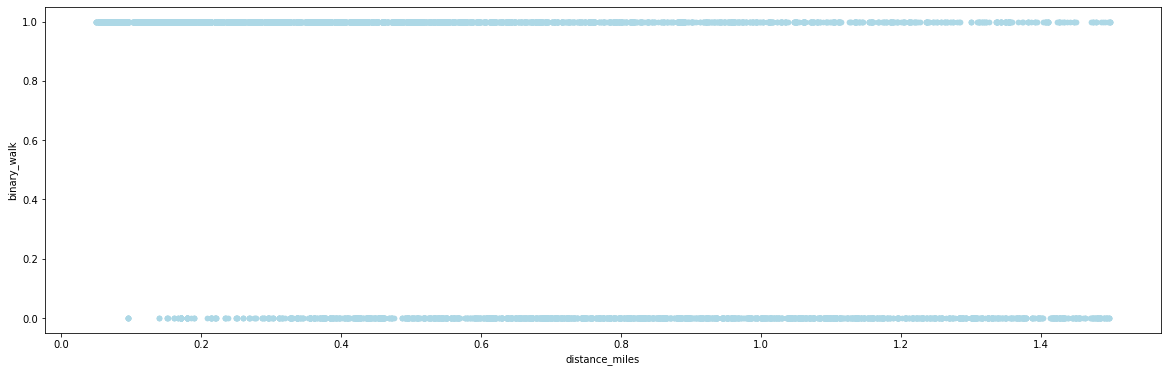

In [ ]:
trips_stu.plot.scatter(x='distance_miles', y='binary_walk', c='LightBlue', figsize=(20,6))
#plt.xlim([0,1.5])
plt.show()

In [ ]:
X = trips_stu[['distance_miles']] # Features
y = trips_stu.binary_walk # Target variable
# instantiate the model (using the default parameters)
model = LogisticRegression(solver='liblinear', random_state=0).fit(X, y)

trips_stu['probability']=pd.DataFrame(model.predict_proba(X)).iloc[:,1]
trips_stu['log_reg']= model.predict(X)
trips_stu.head(10)

,activity_id,mode,duration_minutes,distance_miles,top_amenity,sub_amenity,binary_walk,probability,log_reg
0,6.450312e+18,PRIVATE_AUTO,4.0,1.258175,Education,Universities,0,0.190329,0
1,1.282059e+19,PRIVATE_AUTO,2.0,0.714170,Education,Universities,0,0.595989,1
2,4.303242e+18,PRIVATE_AUTO,1.0,0.535407,Education,Universities,0,0.729544,1
3,9.284786e+18,PRIVATE_AUTO,3.0,0.797499,Education,Universities,0,0.526835,1
4,5.416934e+18,PRIVATE_AUTO,5.0,1.282266,Education,Universities,0,0.178109,0
5,2.349737e+18,PRIVATE_AUTO,2.0,0.817610,Education,Universities,0,0.509885,1
6,9.181386e+18,PRIVATE_AUTO,4.0,1.142401,Education,Universities,0,0.257882,0
7,1.559294e+19,PRIVATE_AUTO,1.0,0.543236,Education,Universities,0,0.724297,1
8,2.559671e+18,PRIVATE_AUTO,2.0,0.863432,Education,Universities,0,0.471243,0
9,1.418419e+19,PRIVATE_AUTO,5.0,1.152955,Education,Universities,0,0.251122,0


In [ ]:
trips_stu[trips_stu['mode']=='PUBLIC_TRANSIT']

,activity_id,mode,duration_minutes,distance_miles,top_amenity,sub_amenity,binary_walk,probability,log_reg
12686,1.699353e+19,PUBLIC_TRANSIT,9.0,0.546122,Education,Universities,0,0.722347,1
12687,1.486965e+19,PUBLIC_TRANSIT,11.0,0.853194,Education,Universities,0,0.479863,0
12688,1.606834e+19,PUBLIC_TRANSIT,19.0,1.315265,Education,Universities,0,0.162381,0
12689,1.646607e+19,PUBLIC_TRANSIT,12.0,1.025163,Education,Universities,0,0.340473,0
12690,7.499039e+18,PUBLIC_TRANSIT,14.0,1.041155,Education,Universities,0,0.328455,0
...,...,...,...,...,...,...,...,...,...
13524,1.143570e+19,PUBLIC_TRANSIT,18.0,1.009795,Education,Universities,0,0.352219,0
13525,1.686607e+19,PUBLIC_TRANSIT,19.0,1.341695,Education,Universities,0,0.150607,0
13526,7.079139e+18,PUBLIC_TRANSIT,18.0,1.324569,Education,Universities,0,0.158153,0
13527,4.985793e+18,PUBLIC_TRANSIT,19.0,1.269393,Education,Universities,0,0.184561,0


In [ ]:
trips_stu[trips_stu['mode']=='PUBLIC_TRANSIT']['probability'].max()

0.8690193816511501

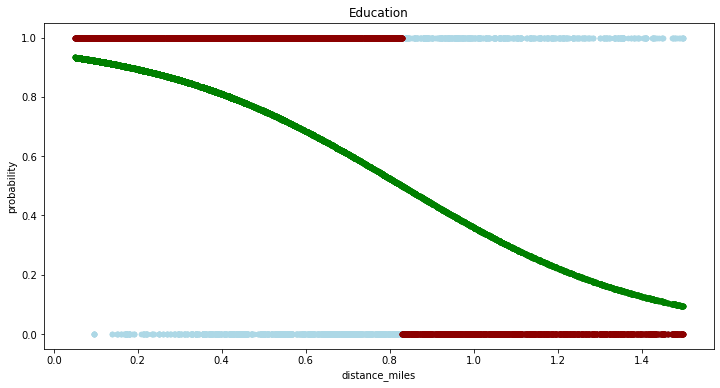

In [ ]:
ax=trips_stu.plot.scatter(x='distance_miles', y='binary_walk', c='LightBlue', figsize=(12,6))
trips_stu.plot.scatter(ax=ax, x='distance_miles', y='log_reg', c='DarkRed', figsize=(12,6))
trips_stu.plot.scatter(ax=ax, x='distance_miles', y='probability', c='Green', figsize=(12,6))
plt.title('Education', y=1)
plt.show()

In [ ]:
dist_array=np.linspace(0, 1.5, num=31)
dist_array

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ])

In [ ]:
dist_df=pd.DataFrame(dist_array).rename(columns = {0:'distance'})
#dist_df['walk_probability']=""
#dist_df['walk_probability']=pd.DataFrame(model.predict_proba(dist_df[['distance']])).iloc[:,1]
name=trips_stu['sub_amenity'].unique()[0]
dist_df.at[:,name]=pd.DataFrame(model.predict_proba(dist_df[['distance']])).iloc[:,1]
dist_df.head(10)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- distance
Feature names seen at fit time, yet now missing:
- distance_miles

  warnings.warn(message, FutureWarning)


,distance,Full-Service Restaurants
0,0.00,0.888818
1,0.05,0.872986
2,0.10,0.855268
3,0.15,0.835543
4,0.20,0.813715
5,0.25,0.789719
6,0.30,0.763531
7,0.35,0.735175
8,0.40,0.704733
9,0.45,0.672352


# Obtain walking probability for each amenity - GENERAL

In [ ]:
walking_time=trips_filt[['top_amenity', 'sub_amenity']]
walking_time=walking_time.drop_duplicates(subset=['sub_amenity']).reset_index().drop('index', axis = 1)
walking_time['dist_limit']=""
walking_time.head(2)

,top_amenity,sub_amenity,dist_limit
0,F&B Eatery,Special Food Services,
1,F&B Eatery,Full-Service Restaurants,


In [ ]:
dist_array=np.linspace(0, 3, num=61)
dist_df=pd.DataFrame(dist_array).rename(columns = {0:'distance'})
dist_df=dist_df.rename(columns={'distance':'distance_miles'})
dist_df.head(70)

,distance_miles
0,0.00
1,0.05
2,0.10
3,0.15
4,0.20
...,...
56,2.80
57,2.85
58,2.90
59,2.95


In [ ]:
trips_filt['mode'].unique()

array(['ON_DEMAND_AUTO', 'CARPOOL', 'BIKING', 'WALKING', 'PRIVATE_AUTO',
       'PUBLIC_TRANSIT', 'OTHER_TRAVEL_MODE'], dtype=object)

In [ ]:
#import pdb
trips_aux=trips_filt[['activity_id', 'mode', 'duration_minutes', 'distance_miles', 'top_amenity', 'sub_amenity']]
#import pdb
for i in range(walking_time['top_amenity'].nunique()):
  #pdb.set_trace()
  top_amenity=walking_time['top_amenity'].unique()[i]

  list_trips_top=trips_aux[trips_aux['top_amenity']==top_amenity]

  for i in range(list_trips_top['sub_amenity'].nunique()):
    sub_amenity=list_trips_top['sub_amenity'].unique()[i]
    list_trips_sub=list_trips_top[list_trips_top['sub_amenity']==sub_amenity]

    if (list_trips_sub.empty == False):
      list_trips_sub['binary_walk'] = np.where(list_trips_sub['mode'] == 'WALKING', 1, 0) #Write here PRIVATE_AUTO, BIKING, or PUBLIC_TRANSIT to obtain the probability of these travel modes

      list_trips_sub=list_trips_sub[list_trips_sub['distance_miles']<3].reset_index(drop=True)
      X = list_trips_sub[['distance_miles']] # Features
      y = list_trips_sub.binary_walk # Target variable
      # initiate the model (using the default parameters)

      if ((not np.any(y)==False)): # If none of the trips to a sub_amenity are taken using the selected travel mode, then "y" array is all zeros. The model cannot throw a prediction. In that case, we say the probability is zero. 
        model = LogisticRegression(solver='liblinear', random_state=0).fit(X, y)

        #name=trips_stu['sub_amenity'].unique()[0]
        aux=dist_df[['distance_miles']]
        dist_df.at[:,sub_amenity]=pd.DataFrame(model.predict_proba(aux)).iloc[:,1]
      
      if ((not np.any(y)==True)):
        dist_df.at[:,sub_amenity]=0
dist_df.head(10)

<ipython-input-25-63fec4a7e17d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_trips_sub['binary_walk'] = np.where(list_trips_sub['mode'] == 'WALKING', 1, 0)
<ipython-input-25-63fec4a7e17d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_trips_sub['binary_walk'] = np.where(list_trips_sub['mode'] == 'WALKING', 1, 0)
<ipython-input-25-63fec4a7e17d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,distance_miles,Special Food Services,Full-Service Restaurants,Limited-Service Restaurants,Drinking Places,Snack and Nonalcoholic Beverage Bars,Hotel and Lodging,Florist,Book Store,Clothing Store,...,Hospitals,Nursing and Residential Care,Offices of Physicians,Religious Centers,Fire Station,Police Station,Public Admin,Bus Station,Train Station,Other Transport Establishments
0,0.00,0.862026,0.887284,0.900012,0.895832,0.897613,0.903103,0.978556,0.975656,0.961147,...,0.905244,0.905087,0.780890,0.924158,0.922709,0.831201,0.917561,0.955650,0.775824,0.962025
1,0.05,0.845555,0.871520,0.885573,0.880855,0.882688,0.889257,0.972727,0.969458,0.952818,...,0.891207,0.890152,0.763683,0.911144,0.909458,0.815457,0.905596,0.948506,0.760702,0.955725
2,0.10,0.827511,0.853914,0.869352,0.864052,0.865911,0.873710,0.965371,0.961744,0.942811,...,0.875378,0.873196,0.745565,0.896147,0.894196,0.798601,0.892099,0.940283,0.744895,0.948435
3,0.15,0.807839,0.834353,0.851218,0.845295,0.847152,0.856332,0.956119,0.952178,0.930834,...,0.857613,0.854052,0.726556,0.878955,0.876710,0.780619,0.876934,0.930843,0.728416,0.940021
4,0.20,0.786502,0.812748,0.831055,0.824475,0.826294,0.837009,0.944538,0.940368,0.916572,...,0.837785,0.832572,0.706685,0.859363,0.856797,0.761511,0.859972,0.920037,0.711286,0.930334
5,0.25,0.763489,0.789038,0.808774,0.801512,0.803251,0.815647,0.930124,0.925869,0.899685,...,0.815789,0.808638,0.685995,0.837188,0.834275,0.741291,0.841097,0.907710,0.693530,0.919218
6,0.30,0.738820,0.763200,0.784318,0.776360,0.777973,0.792180,0.912312,0.908189,0.879829,...,0.791552,0.782179,0.664537,0.812281,0.809002,0.719986,0.820208,0.893702,0.675180,0.906506
7,0.35,0.712546,0.735259,0.757670,0.749019,0.750456,0.766581,0.890494,0.886807,0.856668,...,0.765045,0.753178,0.642378,0.784543,0.780886,0.697643,0.797236,0.877855,0.656276,0.892028
8,0.40,0.684757,0.705295,0.728869,0.719542,0.720752,0.738867,0.864055,0.861207,0.829907,...,0.736291,0.721689,0.619593,0.753949,0.749911,0.674323,0.772144,0.860015,0.636864,0.875617
9,0.45,0.655579,0.673445,0.698008,0.688045,0.688979,0.709112,0.832435,0.830921,0.799319,...,0.705372,0.687849,0.596269,0.720558,0.716148,0.650107,0.744941,0.840044,0.616995,0.857110


In [ ]:
len(dist_df.columns)

84

In [ ]:
dist_df.to_csv('drive/MyDrive/Amenities/output/walking_probability.csv', encoding='utf-8', index=False)

# Number of walking trips

In [ ]:
walking_people=dist_df.copy()
#import pdb
for i in range(frequency['sub_amenity'].nunique()):
  #pdb.set_trace()
  sub_amenity=frequency['sub_amenity'].unique()[i]
  aux1=frequency[frequency['sub_amenity']==sub_amenity]['frequency'][i]
  walking_people[sub_amenity]=dist_df[sub_amenity]*aux1*pop
walking_people.head(2)

,distance,Special Food Services,Full-Service Restaurants,Limited-Service Restaurants,Drinking Places,Snack and Nonalcoholic Beverage Bars,Hotel and Lodging,Florist,Book Store,Clothing Store,...,Hospitals,Nursing and Residential Care,Offices of Physicians,Religious Centers,Fire Station,Police Station,Public Admin,Bus Station,Train Station,Other Transport Establishments
0,0.00,412.464390,21045.063788,10537.387401,4117.850897,10851.567931,3652.570835,1140.874359,542.397867,2217.734726,...,2185.24187,919.842323,127.336272,1668.046683,130.167647,105.085881,65.005517,78.537131,139.590076,287.088017
1,0.05,456.245646,23917.090105,11978.750254,4683.154354,12350.865332,4197.528667,1331.198101,641.115344,2587.736152,...,2518.38623,1057.584272,132.879503,1914.662327,150.110678,112.417459,71.714157,84.352412,136.952891,308.186725


In [ ]:
walking_people.to_csv('drive/MyDrive/Amenities/output/publictransit_trips.csv', encoding='utf-8', index=False)